In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

In [2]:
device = torch.device("cuda")

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

torch.Size([28, 28])   tensor(9)
torch.Size([28, 28])   tensor(1)
torch.Size([28, 28])   tensor(6)
torch.Size([28, 28])   tensor(8)
torch.Size([28, 28])   tensor(8)
torch.Size([28, 28])   tensor(7)
0


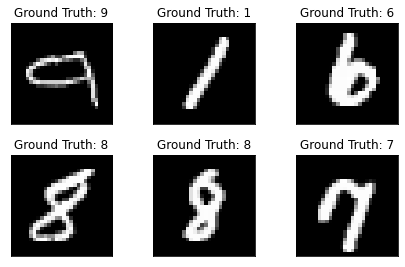

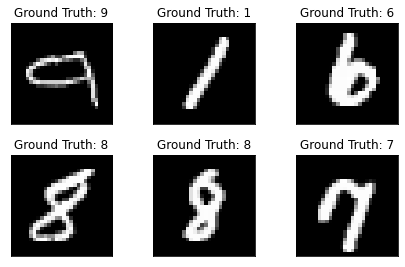

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    print(example_data[i][0].shape, " ", example_targets[i])
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

print(batch_idx)
    
fig

In [4]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        self.fc1 = torch.nn.Linear(256, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        #h = F.relu(F.max_pool2d(self.conv1(x), 2, stride=2))
        #h = F.relu(F.max_pool2d(self.conv2(h), 2, stride=2))
        h = F.max_pool2d(F.relu(self.conv1(x)), 2, stride=2)
        h = F.max_pool2d(F.relu(self.conv2(h)), 2, stride=2)
        h = h.view(h.shape[0], -1)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h #F.softmax(h, dim=-1)


class FeedForward(torch.nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.w1 = torch.nn.Parameter(torch.randn(784, 512) * 0.01)
        self.b1 = torch.nn.Parameter(torch.randn(512) * 0.01)
        self.w2 = torch.nn.Parameter(torch.randn(512, 256) * 0.01)
        self.b2 = torch.nn.Parameter(torch.randn(256) * 0.01)
        self.w3 = torch.nn.Parameter(torch.randn(256, 10) * 0.01)
        self.b3 = torch.nn.Parameter(torch.randn(10) * 0.01)
        
    def forward(self, x):
        x = F.relu(torch.matmul(x, self.w1) + self.b1)
        x = F.relu(torch.matmul(x, self.w2) + self.b2)
        x = torch.matmul(x, self.w3) + self.b3
        return F.softmax(x, dim=-1)

In [5]:
model = FeedForward()

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0015)

#loss = nn.CrossEntropyLoss()
#loss(input, target)

#torch.matmul(tensor1, tensor2)
#model.to('cuda')

for epoch in range(1000):
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        #print(data.shape)
        output = model(data.to(device).view(-1, 784))
        #output = model(data.to(device))
        #print("output.shape ", output.shape)
        #print("target.shape ", target.shape)
        loss = torch.nn.CrossEntropyLoss(reduction="mean")(output, target.to(device))
        #loss = torch.nn.MSELoss(reduction="mean")(output, F.one_hot(target.to(device), num_classes=10).float())
        #print(loss)
        loss.backward()
        #print("Gradient w: {}, b:{}".format(model.conv1.weight.grad, model.conv1.bias.grad))
        optimizer.step()
        
        losses.append(loss.item())
        
        #print('Train Epoch {} Iter: {} Loss: {:.6f}'.format(epoch, batch_idx, loss.item()))
    print('Train Epoch: {} Loss: {:.6f}'.format(epoch, np.mean(losses)))
    
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device).view(-1, 784))
            pred = output.data.max(1, keepdim=True)[1].cpu()
            correct += pred.eq(target.data.view_as(pred)).sum()
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    


AssertionError: Torch not compiled with CUDA enabled